# dataset: satellite-images-of-hurricane-damage

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
base_dir='/kaggle/input/satellite-images-of-hurricane-damage'
train_dir=os.path.join(base_dir,'train_another')
test_dir=os.path.join(base_dir,'test_another')
validation_dir=os.path.join(base_dir,'validation_another')

In [3]:
# Paths to dataset directories
train_dir = "train_another"
valid_dir = "validation_another"
test_dir = "test"


In [4]:

# Global variables
input_shape = (150, 150, 3)
batch_size = 32
num_classes = len(os.listdir(train_dir))  # Number of categories in the training set


In [5]:

# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

valid_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)



In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Updated to match AlexNet input shape
    batch_size=batch_size,
    class_mode="categorical"
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),  # Updated to match AlexNet input shape
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # Updated to match AlexNet input shape
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [7]:

# Callback for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2)


In [8]:

# Helper function for plotting
def plot_history(history, model_name):
    # Plot Accuracy
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(f"{model_name} - Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Plot Loss
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(f"{model_name} - Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [9]:

# Helper function for evaluation
def evaluate_model(model, model_name):
    # Evaluate on test data
    print(f"\nEvaluating {model_name}...")
    loss, accuracy = model.evaluate(test_generator)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Classification Report
    y_true = test_generator.classes
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


In [10]:
# Update input shape for AlexNet (larger image size)
input_shape = (224, 224, 3)

def build_alexnet():
    model = Sequential([
        Conv2D(96, (11, 11), strides=(4, 4), activation="relu", input_shape=input_shape),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), strides=(1, 1), activation="relu", padding="same"),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), activation="relu", padding="same"),
        Conv2D(384, (3, 3), activation="relu", padding="same"),
        Conv2D(256, (3, 3), activation="relu", padding="same"),
        MaxPooling2D((3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation="relu"),
        Dropout(0.5),
        Dense(4096, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    return model


In [11]:
# Model 2: LeNet
def build_lenet():
    model = Sequential([
        Conv2D(6, (5, 5), activation="relu", input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(16, (5, 5), activation="relu"),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(120, activation="relu"),
        Dense(84, activation="relu"),
        Dense(num_classes, activation="softmax")
    ])
    return model

In [12]:
# Model 3: VGG16 (Transfer Learning)
def build_vgg16():
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    return model



Training AlexNet...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


312/312 ━━━━━━━━━━━━━━━━━━━━ 717s 2s/step - accuracy: 0.5072 - loss: 0.7388 - val_accuracy: 0.4990 - val_loss: 0.6935 - learning_rate: 0.0010
Epoch 2/10
  1/312 ━━━━━━━━━━━━━━━━━━━━ 8:59 2s/step - accuracy: 0.5000 - loss: 0.6930

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5000 - loss: 0.6930 - val_accuracy: 0.6250 - val_loss: 0.6877 - learning_rate: 0.0010
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - accuracy: 0.4971 - loss: 0.6935 - val_accuracy: 0.5010 - val_loss: 0.6933 - learning_rate: 0.0010
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 798us/step - accuracy: 0.5625 - loss: 0.6898 - val_accuracy: 0.3750 - val_loss: 0.6975 - learning_rate: 0.0010
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 615s 2s/step - accuracy: 0.5042 - loss: 0.6933 - val_accuracy: 0.4995 - val_loss: 0.6932 - learning_rate: 5.0000e-04
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 815us/step - accuracy: 0.4688 - loss: 0.6935 - val_accuracy: 0.5625 - val_loss: 0.6923 - learning_rate: 5.0000e-04
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 575s 2s/step - accuracy: 0.4986 - loss: 0.6933 - val_accuracy: 0.5010 - val_loss: 0.6931 - learning_rate: 2.5000e-04


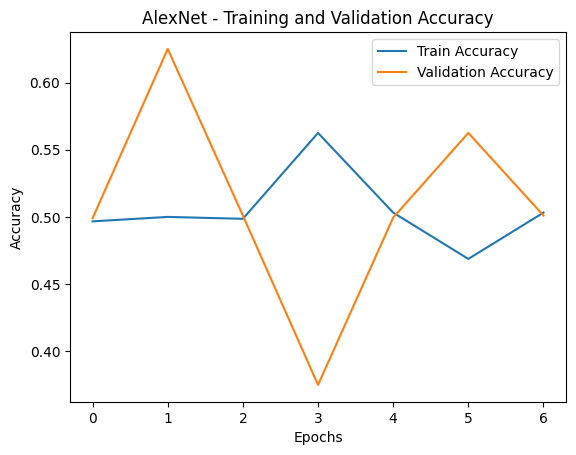

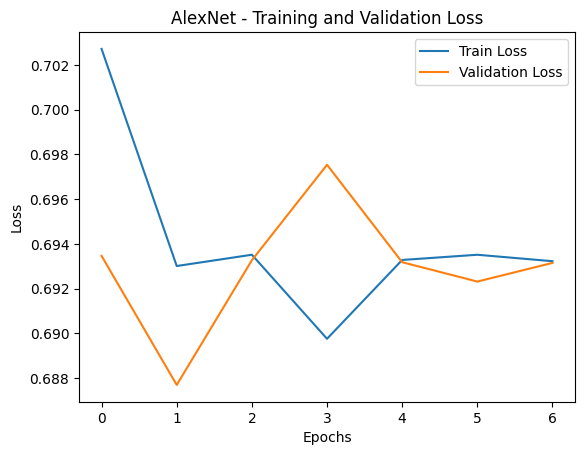


Evaluating AlexNet...
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 666ms/step - accuracy: 0.1655 - loss: 0.7087
Test Accuracy: 50.00%
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 463ms/step
              precision    recall  f1-score   support

      damage       0.00      0.00      0.00      1000
   no_damage       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000


Training LeNet...


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 153s 481ms/step - accuracy: 0.7305 - loss: 0.5506 - val_accuracy: 0.8614 - val_loss: 0.3486 - learning_rate: 0.0010
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 245us/step - accuracy: 0.8750 - loss: 0.3502 - val_accuracy: 1.0000 - val_loss: 0.2346 - learning_rate: 0.0010
Epoch 3/10


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


312/312 ━━━━━━━━━━━━━━━━━━━━ 152s 480ms/step - accuracy: 0.8430 - loss: 0.3816 - val_accuracy: 0.8659 - val_loss: 0.3083 - learning_rate: 0.0010
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 152us/step - accuracy: 0.9062 - loss: 0.3079 - val_accuracy: 0.9375 - val_loss: 0.2318 - learning_rate: 0.0010
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 152s 482ms/step - accuracy: 0.8615 - loss: 0.3263 - val_accuracy: 0.8841 - val_loss: 0.2537 - learning_rate: 0.0010
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 140us/step - accuracy: 0.7812 - loss: 0.3757 - val_accuracy: 0.8750 - val_loss: 0.3350 - learning_rate: 0.0010
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 152s 480ms/step - accuracy: 0.8849 - loss: 0.2689 - val_accuracy: 0.9158 - val_loss: 0.1955 - learning_rate: 5.0000e-04
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 137us/step - accuracy: 0.9375 - loss: 0.1948 - val_accuracy: 0.8750 - val_loss: 0.2813 - learning_rate: 5.0000e-04
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 152s 480ms/step - accuracy: 0.902

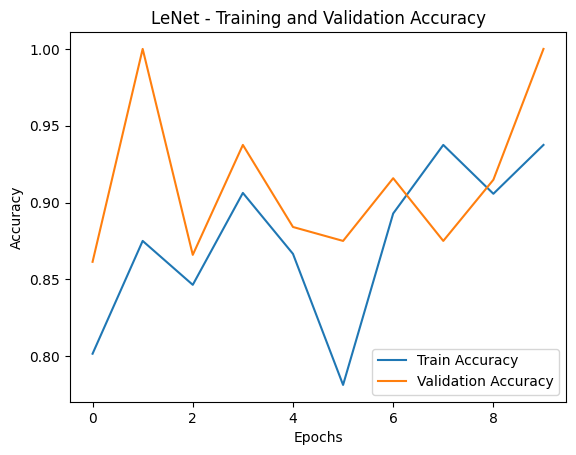

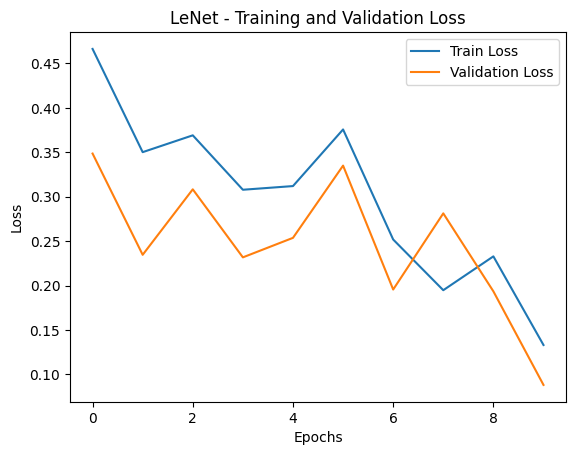


Evaluating LeNet...
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.9010 - loss: 0.2351
Test Accuracy: 90.65%
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step
              precision    recall  f1-score   support

      damage       0.90      0.92      0.91      1000
   no_damage       0.92      0.89      0.91      1000

    accuracy                           0.91      2000
   macro avg       0.91      0.91      0.91      2000
weighted avg       0.91      0.91      0.91      2000



In [13]:
for model_name, build_fn in [("AlexNet", build_alexnet), ("LeNet", build_lenet)]:
    print(f"\nTraining {model_name}...")
    model = build_fn()
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(
        train_generator,
        validation_data=valid_generator,
        epochs=10,
        callbacks=[early_stopping, reduce_lr],
        steps_per_epoch=train_generator.samples // batch_size,
        validation_steps=valid_generator.samples // batch_size
    )
    plot_history(history, model_name)
    evaluate_model(model, model_name)



Training VGG16...
Epoch 1/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 2226s 7s/step - accuracy: 0.8190 - loss: 0.5956 - val_accuracy: 0.9083 - val_loss: 0.2116 - learning_rate: 0.0010
Epoch 2/5
  1/312 ━━━━━━━━━━━━━━━━━━━━ 26:17 5s/step - accuracy: 0.8438 - loss: 0.4509

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8438 - loss: 0.4509 - val_accuracy: 0.9375 - val_loss: 0.1048 - learning_rate: 0.0010
Epoch 3/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 1941s 6s/step - accuracy: 0.8830 - loss: 0.2764 - val_accuracy: 0.9073 - val_loss: 0.2291 - learning_rate: 0.0010
Epoch 4/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9062 - loss: 0.2120 - val_accuracy: 0.9375 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 5/5
312/312 ━━━━━━━━━━━━━━━━━━━━ 1909s 6s/step - accuracy: 0.8788 - loss: 0.2792 - val_accuracy: 0.9178 - val_loss: 0.1859 - learning_rate: 5.0000e-04


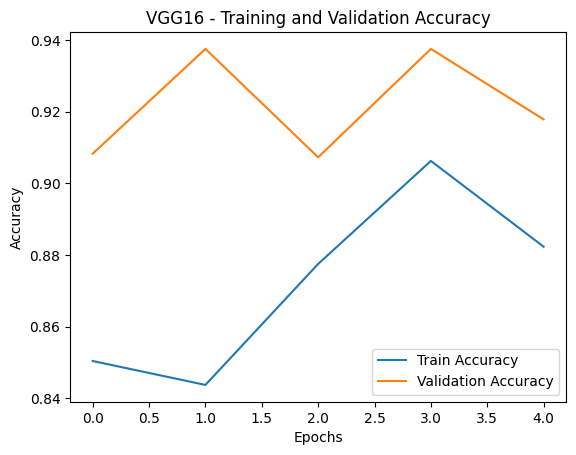

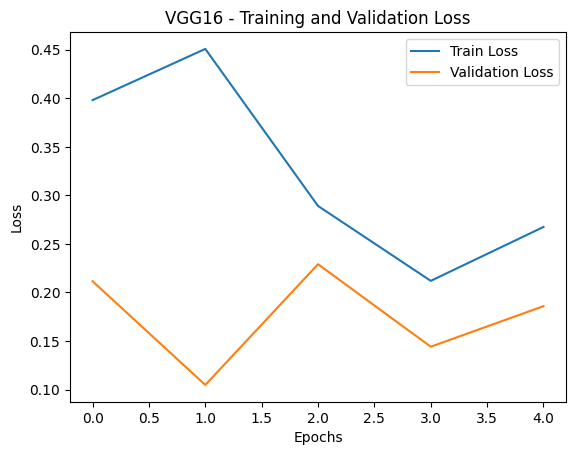


Evaluating VGG16...
63/63 ━━━━━━━━━━━━━━━━━━━━ 307s 5s/step - accuracy: 0.9360 - loss: 0.1799
Test Accuracy: 90.05%
63/63 ━━━━━━━━━━━━━━━━━━━━ 313s 5s/step
              precision    recall  f1-score   support

      damage       0.88      0.93      0.90      1000
   no_damage       0.92      0.87      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



In [14]:
model_name = "VGG16"
build_fn = build_vgg16
print(f"\nTraining {model_name}...")
model = build_fn()
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[early_stopping, reduce_lr],
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=valid_generator.samples // batch_size
)
plot_history(history, model_name)
evaluate_model(model, model_name)
